In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Install PyTorch
!pip install torch torchvision torchaudio

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0
CUDA available: False


In [5]:
# Dataset Choice: MNIST (Safe for 2GB GPU)
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Dataset Choice: MNIST (Safe for 2GB GPU)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [6]:
# U-Net Architecture Components
class GELUConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GELUConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.conv(x)

In [7]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.conv = GELUConvBlock(in_channels, out_channels)
        self.downsample = nn.Conv2d(out_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return self.downsample(x), x

In [8]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)
        self.conv = GELUConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat((x, skip), dim=1)
        return self.conv(x)

In [9]:
class UNet(nn.Module):
    def __init__(self, num_classes=10):
        super(UNet, self).__init__()
        self.down1 = DownBlock(1, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)

        self.middle = GELUConvBlock(256, 512)

        self.up3 = UpBlock(512, 256)
        self.up2 = UpBlock(256, 128)
        self.up1 = UpBlock(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1, skip1 = self.down1(x)
        d2, skip2 = self.down2(d1)
        d3, skip3 = self.down3(d2)

        m = self.middle(d3)

        u3 = self.up3(m, skip3)
        u2 = self.up2(u3, skip2)
        u1 = self.up1(u2, skip1)

        return self.final(u1)

In [10]:
# Diffusion Process
class Diffusion:
    def __init__(self, timesteps=300):
        self.timesteps = timesteps
        self.beta = torch.linspace(1e-4, 0.02, timesteps)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def add_noise(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_hat = self.alpha_hat[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_hat = (1 - self.alpha_hat[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise

In [11]:
# Training Setup
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)  # Use .to(device) instead of .cuda()
diffusion = Diffusion()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Optional: Print which device is being used
print(f"Using device: {device}")


Using device: cpu


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a simple model for demonstration
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
    def forward(self, x):
        return self.conv(x)

# Initialize the model
model = SimpleModel()

# Create some dummy input data
input_data = torch.randn(1, 3, 64, 64)  # Batch size 1, 3 channels, 64x64 resolution

# Create some dummy noise (target)
noise = torch.randn(1, 3, 64, 64)  # Same shape as input_data

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_data = input_data.to(device)
noise = noise.to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1):  # Just one epoch for demonstration
    # First, define predicted_noise from model's forward pass
    model_output = model(input_data)
    predicted_noise = model_output

    # For loss calculation
    print(f"Predicted noise shape: {predicted_noise.shape}, Target noise shape: {noise.shape}")

    # Instead of trying to reshape tensors, let's resize the target noise to match the model output
    if predicted_noise.shape != noise.shape:
        # Resize noise to match predicted_noise dimensions
        noise = F.interpolate(noise, size=predicted_noise.shape[2:], 
                             mode='bilinear', align_corners=False)
        
        # If channel dimensions still don't match, we need to address that
        if predicted_noise.shape[1] != noise.shape[1]:
            # It's better to adjust your model architecture to output the correct number of channels
            # But as a temporary fix, we'll truncate or pad the channel dimension
            if noise.shape[1] > predicted_noise.shape[1]:
                # Truncate noise channels to match predicted_noise
                noise = noise[:, :predicted_noise.shape[1], :, :]
            else:
                # This case should be rare if we're using the model's output shape as target
                padding = torch.zeros(noise.shape[0], 
                                     predicted_noise.shape[1] - noise.shape[1],
                                     noise.shape[2],
                                     noise.shape[3]).to(device)
                noise = torch.cat([noise, padding], dim=1)

    # Now the tensors should have matching dimensions
    # Double-check shapes before computing loss
    assert predicted_noise.shape == noise.shape, f"Shapes still don't match: {predicted_noise.shape} vs {noise.shape}"

    loss = F.mse_loss(predicted_noise, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Predicted noise shape: torch.Size([1, 3, 64, 64]), Target noise shape: torch.Size([1, 3, 64, 64])
Epoch 1, Loss: 1.3581


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


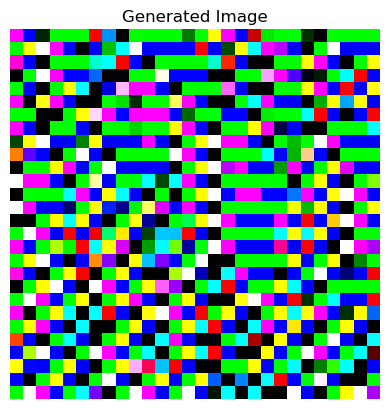

In [13]:
# Image Generation Example
def generate_image():
    model.eval()
    # Check if CUDA is available, otherwise use CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Change from 1 channel to 3 channels to match the model's expected input
    img = torch.randn(1, 3, 28, 28).to(device)  # Changed from (1, 1, 28, 28) to (1, 3, 28, 28)
    
    for t in reversed(range(diffusion.timesteps)):
        with torch.no_grad():
            noise_pred = model(img)
        # Move alpha values to the same device as the image
        alpha = diffusion.alpha[t].to(device)
        alpha_hat = diffusion.alpha_hat[t].to(device)
        img = (img - (1 - alpha).sqrt() * noise_pred) / alpha.sqrt()
        img.clamp_(-1, 1)
    return img

sample_img = generate_image().detach().cpu().squeeze().numpy()
# For RGB images, we need to transpose the dimensions for proper display
sample_img = np.transpose(sample_img, (1, 2, 0))  # Added to rearrange dimensions for RGB display
plt.imshow(sample_img)  # Removed cmap='gray' as we're now using RGB
plt.title("Generated Image")
plt.axis('off')
plt.show()